In [1]:
import pandas as pd
import numpy as np
import requests
import datetime as dt
import yfinance as yf # To download stock prices from Yahoo Finance

url = 'https://en.wikipedia.org/wiki/List_of_S&P_500_companies'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36'
}

response = requests.get(url, headers=headers)
sp500 = pd.read_html(response.text)[1]
# Take correct symbol column from Wiki
symbol_col = [col for col in sp500.columns if col == 'Symbol'][0]
# Correct symbol's format
sp500['Symbol'] = sp500[symbol_col].str.replace('.', '_')
# Take the list of unique symbols
symbols = sp500['Symbol'].unique().tolist()
# Fix the symbol BRK-B, BF-B
symbols = [s.replace('BRK_B', 'BRK-B').replace('BF_B', 'BF-B') if s in ['BRK_B', 'BF_B'] else s for s in symbols]
# Take the range of time
end_date = dt.datetime.today()
start_date = end_date - pd.DateOffset(years=8)
# Download stock prices from these symbols
df = yf.download(tickers = symbols,
                 start = start_date,
                 end = end_date,
                 progress=True,
                 auto_adjust=False)

# Assign names to the MultiIndex columns of df
df.columns = df.columns.set_names(['metric', 'ticker'])
# Transform the DataFrame from wide to long format by stacking the 'ticker' level of the columns
df = df.stack(level='ticker', future_stack=True)
# Assign names to the resulting MultiIndex index
df.index.names = ['date', 'ticker']
# Remove the name of the remaining column level
df.columns.name = None
# Convert column names to lowercase
df.columns = df.columns.str.lower()
# Sort the index to ensure proper chronological order for each ticker
df = df.sort_index()

# Drop rows where 'close' price is NaN (failed downloads for specific dates/tickers)
df = df.dropna(subset=['close'])

print("DataFrame head:")
display(df.head())
print("\nDataFrame info:")
df.info()

/var/folders/2c/m_n_s4tn1yl_wl0vsn5dn3880000gn/T/ipykernel_51527/3402436489.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500 = pd.read_html(response.text)[1]
[*********************100%***********************]  503 of 503 completed


DataFrame head:


adj close      close       high        low       open  \
date       ticker                                                          
2017-11-27 A       65.250458  69.309998  69.489998  69.169998  69.220001   
           AAPL    40.770458  43.522499  43.770000  43.334999  43.762501   
           ABBV    67.777786  95.419998  95.629997  94.440002  94.690002   
           ABT     48.786594  56.150002  56.520000  56.009998  56.169998   
           ACGL    30.517504  32.093334  32.139999  31.826668  31.873333   

                       volume  
date       ticker              
2017-11-27 A        1439300.0  
           AAPL    82867200.0  
           ABBV     3044600.0  
           ABT      4518300.0  
           ACGL      942900.0


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 989452 entries, (Timestamp('2017-11-27 00:00:00'), 'A') to (Timestamp('2025-11-25 00:00:00'), 'ZTS')
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   adj close  989452 non-null  float64
 1   close      989452 non-null  float64
 2   high       989452 non-null  float64
 3   low        989452 non-null  float64
 4   open       989452 non-null  float64
 5   volume     989452 non-null  float64
dtypes: float64(6)
memory usage: 49.1+ MB


# 1. Calculate technical indicators for each stock
## 1.1. Garman-Klass Volatility
### 1.1.1. Definition

The Garman-Klass Volatility (GKV) is a measure of historical volatility that utilizes four price points: Open, High, Low, and Close prices of a trading period. Providing an estimator of true volatility, especially when dealing with daily data.

### 1.1.2. Formulas

The Garman-Klass volatility is calculated in two main steps:

#### 1. Daily Garman-Klass Estimator ($GK_t$):

For each trading period $t$ (typically a day), the daily Garman-Klass estimator is:

$$GK_t = \frac{1}{2}\ln\left(\frac{\text{High}_t}{\text{Low}_t}\right)^2 - (2\ln 2 - 1) \ln\left(\frac{\text{Close}_t}{\text{Open}_t}\right)^2$$

*   $\text{High}_t$: The highest price reached during the trading period $t$.
*   $\text{Low}_t$: The lowest price reached during the trading period $t$.
*   $\text{Close}_t$: The closing price of the trading period $t$.
*   $\text{Open}_t$: The opening price of the trading period $t$.
*   $\ln()$: The natural logarithm.

    *   The first term, $\frac{1}{2}\ln\left(\frac{\text{High}_t}{\text{Low}_t}\right)^2$, measures volatility due to the range between the high and low prices. This captures the magnitude of price movement within the day.
    *   The second term, $-(2\ln 2 - 1) \ln\left(\frac{\text{Close}_t}{\text{Open}_t}\right)^2$, adjusts for the directional movement from open to close. The constant $(2\ln 2 - 1)$ is approximately $0.386$.

#### 2. Annualized Garman-Klass Volatility:

The daily estimators are averaged over a specified rolling window (e.g., 20 days for monthly periods) and then scaled by the square root of the number of trading days in a year (typically 252).

$$ \text{Garman-Klass Volatility} = \sqrt{252 \times \overline{GK_t}} $$

*   $\overline{GK_t}$: Average of the daily Garman-Klass estimators
*   $252$: Standard number of trading days in a year

In [2]:
def garman_klass_vol(g: pd.DataFrame, window: int = 20) -> pd.Series:
    # Ensure all required columns are present
    required_cols = ['high', 'low', 'close', 'open']
    if not all(col in g.columns for col in required_cols):
        return pd.Series(np.nan, index=g.index, name='gk_vol') # Return NaNs if data is incomplete

    # Daily GK estimator
    log_hl = np.log(g['high'] / g['low'])
    log_co = np.log(g['close'] / g['open'])
    rs = 0.5 * log_hl**2 - (2*np.log(2) - 1) * log_co**2

    # Rolling mean → average estimator over the window
    gk_mean = rs.rolling(window, min_periods=window).mean()

    # Annualise (252 trading days per year)
    gk_vol = np.sqrt(252 * gk_mean)

    return gk_vol

In [3]:
# Apply Garman-Klass Volatility
df['gk_vol'] = df.groupby('ticker', group_keys=False).apply(
                   lambda g: garman_klass_vol(g, window=20))

## 1.2. RSI (Relative Strength Index)
The **Relative Strength Index (RSI)** measures the speed and change of price movements, telling you if a stock's price changes have been too strong in one direction. Helping us to identify a stock is 'overbought' or 'oversold'.

*   **Overbought**: When RSI is high (typically above 70), it suggests that the stock's price has increased very rapidly and might be due for a pullback or a correction.
*   **Oversold**: When RSI is low (typically below 30), it indicates that the stock's price has fallen sharply and might be due for a rebound.
*   **RSI between 30 and 70**: Generally considered a neutral zone, indicating no strong overbought or oversold conditions. An RSI around 50 often suggests a lack of strong trend.
*   **Divergence**: Sometimes, the stock price makes a new high, but the RSI makes a lower high. This is called a 'bearish divergence' and can be a strong signal that the upward trend is weakening. Conversely, a 'bullish divergence' (price makes a new low, but RSI makes a higher low) can signal that a downtrend is losing strength.

In [4]:
import pandas_ta as ta

df['rsi'] = df.groupby('ticker', group_keys=False).apply(
                lambda g: ta.rsi(close=g['close'], length=14))

## 1.3. Bollinger Bands

**Bollinger Bands** measure a market's volatility and identify potential overbought or oversold conditions. 

1.  **Middle Band (Simple Moving Average - SMA)**:
    *   A 20-period Simple Moving Average of the closing prices. It represents the "normal" or average price over that period.
    *   It acts as the baseline for the other two bands.

2.  **Upper Band**:
    *   Calculated by adding a certain number of standard deviations (usually 2) to the Middle Band.
    *   When prices touch or exceed the Upper Band, it suggests that the asset might be overbought or that its price is unusually high relative to its recent average.

3.  **Lower Band**:
    *   Calculated by subtracting the same number of standard deviations (usually 2) from the Middle Band.
    *   When prices touch or fall below the Lower Band, it can indicate that the asset might be oversold or that its price is unusually low.

- When the bands are wide apart, it suggests high volatility (prices are moving a lot). When they are close together (contracting), it indicates low volatility (prices are relatively stable).
- The bands act like dynamic support and resistance levels. Prices tend to stay within these bands. A move outside the bands can signal that the price has reached an extreme and might be due for a reversal back towards the Middle Band.

In [5]:
bb_cols_map = {
    'BBL_20_2.0': 'bb_lower',
    'BBM_20_2.0': 'bb_middle',
    'BBU_20_2.0': 'bb_upper',
    'BBB_20_2.0': 'bb_width',
    'BBP_20_2.0': 'bb_percent_b' # %B, (Close - Lower)/(Upper - Lower)
}
bb = df.groupby('ticker', group_keys=False).apply(
    lambda g: ta.bbands(close=g['close'], length=20, std=2)
).rename(columns=bb_cols_map)
df = df.join(bb)

## 1.4. ATR (Average True Range)
The **Average True Range (ATR)** measures market volatility by calculating the average range of an asset's price over a specified period. Unlike other indicators that focus on price direction or momentum, ATR specifically quantifies how much an asset moves on average.

It does this by considering the most comprehensive measure of an asset's daily price range, which includes:

1.  **The distance between the current high and current low.**
2.  **The distance between the current high and the previous day's close.**
3.  **The distance between the current low and the previous day's close.**

ATR then takes the largest of these three values (the "True Range") and averages it over a set number of periods (commonly 14 days or periods). This provides a clearer picture of the typical price movement, helping to filter out day-to-day noise.

*   **Higher ATR values** indicate **higher volatility**. This means the price is moving more dramatically, and potential price swings (up or down) are larger. Traders might see this as an opportunity for bigger gains or losses.

*   **Lower ATR values** suggest **lower volatility**. The price is moving in a relatively stable or quiet manner, with smaller daily price ranges.

This only tells you *how much* the price is moving.

In [6]:
df['atr'] = df.groupby('ticker', group_keys=False).apply(
                lambda g: ta.atr(high=g['high'], low=g['low'], close=g['close'], length=14))

## 1.5. MACD (Moving Average Convergence Divergence)

The Moving Average Convergence Divergence (MACD) is a **trend-following momentum indicator** that shows the relationship between two moving averages of a security's price. It helps traders identify potential buying and selling opportunities by revealing changes in a stock's strength, direction, momentum, and duration of a trend. Think of it as a tool that condenses a lot of price action into a few easy-to-understand lines, helping to spot when a stock's momentum is picking up or slowing down.

### Components of MACD

The MACD indicator is composed of three main elements:

1.  **MACD Line (Fast Line):** This is the core of the indicator. It's calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. This line measures momentum; when the 12-period EMA (which reacts faster to price changes) moves away from the 26-period EMA (which reacts slower), it indicates increasing momentum in that direction.
    
2.  **Signal Line (Slow Line):** This is typically a 9-period EMA of the MACD Line itself. It acts as a trigger for buy and sell signals. Because it's an average of the MACD Line, it moves slower and helps confirm trends or reversals.
    
3.  **MACD Histogram:** This visually represents the difference between the MACD Line and the Signal Line. It fluctuates above and below a zero line. When the histogram is above zero, the MACD Line is above the Signal Line, suggesting bullish momentum. When it's below zero, the MACD Line is below the Signal Line, indicating bearish momentum. The height of the bars shows the strength of this momentum.

Trend-following momentum indicator.
$$
\text{EMA}_{12} = \text{EMA}(C_t, 12), \quad \text{EMA}_{26} = \text{EMA}(C_t, 26)
$$
$$
MACD\ \text{Line} = EMA_{12} - EMA_{26}
$$
$$
Signal\ \text{Line} = EMA(MACD\ \text{Line}, 9)
$$
$$
Histogram = MACD\ \text{Line} - Signal\ \text{Line}
$$

In [7]:
macd_cols_map = {
    'MACD_12_26_9': 'macd',
    'MACDH_12_26_9': 'macd_hist',
    'MACDS_12_26_9': 'macd_signal'
}
macd_df = df.groupby('ticker', group_keys=False).apply(
    lambda g: ta.macd(close=g['close'], fast=12, slow=26, signal=9)
).rename(columns=macd_cols_map)
df = df.join(macd_df)

## 1.6. Dollar Volume
Dollar Volume represents the total monetary value of a particular asset (like a stock) over a specific period, usually a day. It's calculated by multiplying the asset's **closing price** by the **number of shares (or volume) traded** during that period.

$$ \text{Dollar Volume}_t = C_t \times \text{Volume}_t $$

Where:
*   $C_t$: The closing price of the asset on day $t$.
*   $\text{Volume}_t$: The number of shares traded on day $t$.$$

In [8]:
def dollar_volume(g: pd.DataFrame) -> pd.Series:
    if not all(col in g.columns for col in ['close', 'volume']):
        return pd.Series(np.nan, index=g.index, name='dollar_volume') # Return NaNs if data is incomplete
    return g['close'] * g['volume']

In [9]:
df['dollar_volume'] = df.groupby('ticker', group_keys=False).apply(dollar_volume)

In [10]:
df = df.sort_index()

print("New columns added:")
print(df.columns.tolist())

print("\nDataFrame head with new indicators:")
display(df.tail())

print("\nDataFrame info after adding indicators:")
df.info()

New columns added:
['adj close', 'close', 'high', 'low', 'open', 'volume', 'gk_vol', 'rsi', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'atr', 'macd', 'MACDh_12_26_9', 'MACDs_12_26_9', 'dollar_volume']

DataFrame head with new indicators:


adj close       close        high         low        open  \
date       ticker                                                               
2025-11-25 XYZ      62.349998   62.349998   62.480000   61.990002   62.014999   
           YUM     152.779999  152.779999  152.919998  151.115494  153.110001   
           ZBH      94.269997   94.269997   94.680000   94.110001   93.180000   
           ZBRA    244.919998  244.919998  245.509995  242.699997  242.880005   
           ZTS     124.180000  124.180000  124.739998  123.449997  121.629997   

                     volume    gk_vol        rsi  BBL_20_2.0_2.0  \
date       ticker                                                  
2025-11-25 XYZ     222095.0  0.457067  36.964607       54.370765   
           YUM      21646.0  0.203986  61.040068      138.302578   
           ZBH      17769.0  0.329931  51.299832       82.409929   
           ZBRA     13276.0  0.334157  40.015925      222.578318   
           ZTS     134740.0  0.256552  41.699435      105.290907   

                   BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
date       ticker                                                   
2025-11-25 XYZ          66.559000       78.747236       36.623854   
           YUM         147.493001      156.683424       12.462182   
           ZBH          92.570000      102.730070       21.951108   
           ZBRA        251.062498      279.546678       22.690908   
           ZTS         125.169501      145.048095       31.762680   

                   BBP_20_2.0_2.0       atr       macd  MACDh_12_26_9  \
date       ticker                                                       
2025-11-25 XYZ           0.327333  2.979982  -3.770673      -0.133682   
           YUM           0.787636  2.760689   1.549984       0.514093   
           ZBH           0.583661  2.576240  -1.832973       0.589567   
           ZBRA          0.392177  9.291731 -13.541978       0.709924   
           ZTS           0.475111  3.293802  -5.334580       0.780630   

                   MACDs_12_26_9  dollar_volume  
date       ticker                                
2025-11-25 XYZ         -3.636990   1.384762e+07  
           YUM          1.035891   3.307076e+06  
           ZBH         -2.422540   1.675084e+06  
           ZBRA       -14.251902   3.251558e+06  
           ZTS         -6.115210   1.673201e+07


DataFrame info after adding indicators:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 989452 entries, (Timestamp('2017-11-27 00:00:00'), 'A') to (Timestamp('2025-11-25 00:00:00'), 'ZTS')
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   adj close       989452 non-null  float64
 1   close           989452 non-null  float64
 2   high            989452 non-null  float64
 3   low             989452 non-null  float64
 4   open            989452 non-null  float64
 5   volume          989452 non-null  float64
 6   gk_vol          979895 non-null  float64
 7   rsi             988944 non-null  float64
 8   BBL_20_2.0_2.0  979895 non-null  float64
 9   BBM_20_2.0_2.0  979895 non-null  float64
 10  BBU_20_2.0_2.0  979895 non-null  float64
 11  BBB_20_2.0_2.0  979895 non-null  float64
 12  BBP_20_2.0_2.0  979895 non-null  float64
 13  atr             982913 non-null  float64
 14  macd            976878 non-null  f

# 2. Aggregate to monthly level and filter top 150 most liquid stocks for each month
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency. There are the following steps:
- Convert daily data → monthly frequency
- Keep only the top 150 most liquid stocks each month (by 1-year average dollar volume)
- Reduce dataset size for faster ML/backtesting

In [11]:
# List of all feature columns except raw price/volume
last_cols = [c for c in df.columns.unique(0)
             if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'adj close']]

# Perform monthly aggregation
data = (
    df.groupby(['ticker', pd.Grouper(level='date', freq='ME')])
      .agg({
          'dollar_volume': 'mean',             # Mean for dollar volume
          **{col: 'last' for col in last_cols} # Last for other features
      })
)

# The index will be ticker, date after this operation. Swap levels for consistency.
data = data.swaplevel('ticker', 'date').sort_index()

# Calculate 5-year rolling average dollar volume for each stock
data['dollar_volume'] = (
    data.loc[:, 'dollar_volume']
        .unstack('ticker')
        .rolling(5 * 12, min_periods=12).mean()
        .stack()
)

# For each month, rank stocks by 5-year average dollar volume
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

# Filter to keep only the top 150 most liquid stocks for each month
data = data[data['dollar_vol_rank'] < 151]

# Drop the temporary dollar_volume (5-year rolling average) and dollar_vol_rank columns
data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# Display the head of the resulting data DataFrame and its information
print("DataFrame head after monthly aggregation and filtering:")
display(data.head())
print("\nDataFrame info after monthly aggregation and filtering:")
data.info()

DataFrame head after monthly aggregation and filtering:


close    gk_vol        rsi  BBL_20_2.0_2.0  \
date       ticker                                                    
2018-10-31 AAPL     54.715000  0.308725  49.700886       52.680816   
           ABBV     77.849998  0.314281  26.090925       76.114146   
           ABT      68.940002  0.249685  50.563240       65.864146   
           ACN     157.619995  0.220038  44.337507      148.100149   
           ADBE    245.759995  0.438552  46.500273      231.497302   

                   BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
date       ticker                                                   
2018-10-31 AAPL         54.885500       57.090184        8.033759   
           ABBV         87.663000       99.211853       26.348297   
           ABT          69.065499       72.266853        9.270485   
           ACN         159.928999      171.757848       14.792626   
           ADBE        248.901000      266.304698       13.984434   

                   BBP_20_2.0_2.0        atr      macd  MACDh_12_26_9  \
date       ticker                                                       
2018-10-31 AAPL          0.461332   1.645572 -0.346485      -0.151236   
           ABBV          0.075153   2.691090 -3.756468      -0.905173   
           ABT           0.480399   1.611579 -0.461338      -0.180597   
           ACN           0.402399   3.633331 -3.540325      -0.173525   
           ADBE          0.409760  11.181375 -4.721453      -0.489512   

                   MACDs_12_26_9  
date       ticker                 
2018-10-31 AAPL        -0.195250  
           ABBV        -2.851295  
           ABT         -0.280741  
           ACN         -3.366800  
           ADBE        -4.231941


DataFrame info after monthly aggregation and filtering:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12900 entries, (Timestamp('2018-10-31 00:00:00'), 'AAPL') to (Timestamp('2025-11-30 00:00:00'), 'XYZ')
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           12900 non-null  float64
 1   gk_vol          12900 non-null  float64
 2   rsi             12900 non-null  float64
 3   BBL_20_2.0_2.0  12900 non-null  float64
 4   BBM_20_2.0_2.0  12900 non-null  float64
 5   BBU_20_2.0_2.0  12900 non-null  float64
 6   BBB_20_2.0_2.0  12900 non-null  float64
 7   BBP_20_2.0_2.0  12900 non-null  float64
 8   atr             12900 non-null  float64
 9   macd            12900 non-null  float64
 10  MACDh_12_26_9   12900 non-null  float64
 11  MACDs_12_26_9   12900 non-null  float64
dtypes: float64(12)
memory usage: 1.2+ MB


# 3. Calculating Monthly Returns for Time Series Features
This section generates momentum-style return features, which are crucial for understanding how stock prices have performed over various time horizons. These features help capture trends and potential reversals in stock prices.
There are the following steps:
- Add momentum-style return features at multiple horizons (1-month, 2-month, 3-month, 6-month, 9-month, 1-year)
- Clean outliers and annualize the returns
- Apply per stock using groupby on the ticker level

> - **Momentum Patterns**: These refer to the tendency of assets that have performed well in the recent past to continue to perform well in the future, and similarly for poor performers. By calculating returns over different `lags` (e.g., 1-month, 3-month), we create features that can identify these patterns.
> - **Outliers**: They are extreme values that deviate significantly from other observations. These can be caused by unusual market events (e.g., flash crashes, sudden news) or data errors. Cleaning outliers, often through a technique called **Winsorization**, helps prevent these extreme values from unduly influencing models.
> - **Winsorization**: Extreme values in a dataset are replaced with values at a specified percentile. For instance, if outlier_cutoff is 0.005, the bottom 0.5% of returns are replaced by the value at the 0.5th percentile, and the top 0.5% are replaced by the value at the 99.5th percentile. This caps extreme values while preserving the rank order of the data.
> - **Per-month Return** (e.g. a 6-month return): The average return per month compounded. It's calculated as (1 + total_return)^(1/number_of_months) - 1

### Python Explanation:
*   `pct_change(lag)`: This function calculates the percentage change between the current value and a value `lag` periods ago. For example, `df['close'].pct_change(1)` gives the 1-period (monthly) return.
*   `df.groupby(level=1, group_keys=False).apply(calculate_returns)`:
    *   `groupby(level=1)`: This groups the DataFrame by the second level of its MultiIndex, which is 'ticker' in our `data` DataFrame. This ensures that calculations (like returns) are performed independently for each stock.
    *   `group_keys=False`: This prevents the group keys (tickers) from being added back as an index level in the output, keeping the DataFrame structure cleaner.
    *   `apply(calculate_returns)`: This method applies a custom function (`calculate_returns` in this case) to each group. It's a powerful way to perform complex, group-specific operations.

*   `lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))`: This is an anonymous function within the `.pipe()` method. It takes a Series `x` (the returns for a specific lag), calculates its `outlier_cutoff` and `1-outlier_cutoff` quantiles, and then uses `.clip()` to replace values outside this range with the quantile values.

In [12]:
def calculate_returns(df_group: pd.DataFrame) -> pd.DataFrame:

    # trim 0.5% from each tail for outlier cleaning
    outlier_cutoff = 0.005
    # Define lookback periods in months for momentum features
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        # Calculate total return over the specified lag period
        df_group[f'return_{lag}m'] = (
            df_group['close']
            .pct_change(lag)  # Calculate percentage change over 'lag' months
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                   upper=x.quantile(1 - outlier_cutoff))) # Winsorize outliers
            .add(1)           # Convert to gross return (1 + r)
            .pow(1 / lag)     # Annualize to per-month return (if lag > 1)
            .sub(1)           # Convert back to net per-month return
        )
    return df_group

# Apply the function to each stock group and drop any rows with NaN values resulting from calculations
data = data.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()

print("DataFrame with monthly return features:")
display(data.head())
print("\nDataFrame info after adding return features:")
data.info()

DataFrame with monthly return features:


close    gk_vol        rsi  BBL_20_2.0_2.0  \
date       ticker                                                    
2019-10-31 AAPL     62.189999  0.188614  70.814642       55.582010   
           ABBV     79.550003  0.172564  71.311204       71.872354   
           ABT      83.610001  0.197176  56.807025       78.541297   
           ACN     185.419998  0.149700  46.903299      181.526269   
           ADBE    277.929993  0.184447  55.299942      261.218188   

                   BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
date       ticker                                                   
2019-10-31 AAPL         59.340250       63.098490       12.666748   
           ABBV         76.038501       80.204648       10.957995   
           ABT          81.488000       84.434703        7.232238   
           ACN         185.292500      189.058731        4.065174   
           ADBE        272.296501      283.374815        8.136949   

                   BBP_20_2.0_2.0       atr      macd  MACDh_12_26_9  \
date       ticker                                                      
2019-10-31 AAPL          0.879133  1.150600  1.668786       0.089590   
           ABBV          0.921433  1.385443  1.859733       0.198578   
           ABT           0.860064  1.581873  0.215541       0.412678   
           ACN           0.516926  3.211849 -1.401475       0.330531   
           ADBE          0.754258  6.127357 -1.151722       1.350748   

                   MACDs_12_26_9  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                              
2019-10-31 AAPL         1.579196   0.110684   0.091660   0.053028   0.036453   
           ABBV         1.661155   0.050581   0.100032   0.060910   0.000336   
           ABT         -0.197136  -0.000717  -0.010072  -0.013539   0.008310   
           ACN         -1.732005  -0.036028  -0.032704  -0.012550   0.002493   
           ADBE        -2.502470   0.006081  -0.011631  -0.023911  -0.006632   

                   return_9m  return_12m  
date       ticker                         
2019-10-31 AAPL     0.045662    0.010728  
           ABBV    -0.001028    0.001802  
           ABT      0.015223    0.016207  
           ACN      0.021176    0.013628  
           ADBE     0.012822    0.010304


DataFrame info after adding return features:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10613 entries, (Timestamp('2019-10-31 00:00:00'), 'AAPL') to (Timestamp('2025-11-30 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           10613 non-null  float64
 1   gk_vol          10613 non-null  float64
 2   rsi             10613 non-null  float64
 3   BBL_20_2.0_2.0  10613 non-null  float64
 4   BBM_20_2.0_2.0  10613 non-null  float64
 5   BBU_20_2.0_2.0  10613 non-null  float64
 6   BBB_20_2.0_2.0  10613 non-null  float64
 7   BBP_20_2.0_2.0  10613 non-null  float64
 8   atr             10613 non-null  float64
 9   macd            10613 non-null  float64
 10  MACDh_12_26_9   10613 non-null  float64
 11  MACDs_12_26_9   10613 non-null  float64
 12  return_1m       10613 non-null  float64
 13  return_2m       10613 non-null  float64
 14  return_3m       10613 non-null  float64
 15

# 4. Fama-French Factors & Rolling Factor Betas
### 5 Fama-French Factors

Before Fama and French, investors relied on the CAPM model, which believed there was only one risk: the Market. Fama and French argued that stock returns are not random; they are compensation for taking on specific types of risks.

1.  **Market Risk (Mkt-RF / Excess Return of the Market)**: The return of the entire stock market minus the risk-free rate.

    > * "A rising tide lifts all boats" --> If the whole economy is booming, most stocks go up. You need to know how much your stock moves simply because the S&P 500 is moving.
    > * **How to calculate**: The return of the market portfolio minus the risk-free rate ($R_M - R_f$).

2.  **Small Minus Big (SMB / Size Factor)**: The difference in returns between Small companies and Big companies.

    > * Small companies (Small Caps) are riskier, have less access to cash, and are more fragile than giants like Microsoft or Apple. Therefore, investors demand a higher return for holding them.
    > * **How to calculate**: Taking the average return of portfolios of small-cap stocks and subtracting the average return of portfolios of large-cap stocks. It is typically size-weighted.
      
3.  **High Minus Low (HML / Value Factor)**: The difference between "Value" stocks (High Book-to-Market ratio) and "Growth" stocks (Low Book-to-Market ratio).

    > * **Value stocks**: Think of Ford or GM. They might look "cheap" or boring. They are risky because they might be in distress.
    > * **Growth stocks**: Think of Nvidia or Tesla. They are expensive because everyone expects them to grow.
    > * **How to calculate**: Subtracting the average return of portfolios of low book-to-market (growth) stocks from the average return of portfolios of high book-to-market (value) stocks.

4.  **Robust Minus Weak (RMW / Profitability Factor)**: Companies with Robust (high) operating profitability vs. Weak (low) profitability.

    > * It sounds obvious, but companies that actually make money (high margins) tend to be safer and perform better over time than companies that burn cash. -->  filters out "junk" stocks
    > * **How to calculate**: Subtracting the average return of portfolios of low profitability stocks from the average return of portfolios of high profitability stocks.

5.  **Conservative Minus Aggressive (CMA / Investment Factor)**: Companies that invest Conservatively vs. those that invest Aggressively (expanding too fast).
    > * Companies that expand too aggressively (building too many factories, acquiring too many competitors) often misallocate capital and lower their returns. Conservative companies are more efficient.
    > * **How to calculate**: Subtracting the average return of portfolios of high investment stocks from the average return of portfolios of low investment stocks

### Rolling Factor Betas

**Beta is Sensitivity**
  - If the Value Factor (HML) goes up 1%, and Stock A goes up 0.5%, the Beta is 0.5.
  - If Stock B goes down -1.0%, the Beta is -1.0 (Inverse relationship).

**Why "Rolling"?**
- The Problem: A company changes over time.
  - Amazon in 1999: It was a small, risky, aggressive company.
  - Amazon in 2024: It is a massive, highly profitable, established company.
- The Solution: If you calculate one single Beta for the last 20 years, it will be wrong.
- Rolling Beta: You calculate the sensitivity inside a moving window (e.g., the last 126 trading days) --> recalculate this every single day.

### Python Explanation
* **`pandas_datareader.web.DataReader`**: Provides an easy way to read data from various internet sources into pandas DataFrames. In this context, it's used to download financial data, specifically the Fama-French 5-Factor Model data ('F-F_Research_Data_5_Factors_2x3') from the Fama/French data library.
* **`statsmodels.api` (as `sm`)**: Library for the estimation of many different statistical models, as well as for conducting statistical tests and statistical data exploration.
* **`statsmodels.regression.rolling.RollingOLS`**: Used to perform rolling Ordinary Least Squares (OLS) regressions. Instead of fitting one OLS model over the entire dataset, `RollingOLS` fits separate OLS models on a rolling window of data. --> Rolling betas for each stock against the Fama-French factors. The window size (`window`) and minimum number of observations (`min_nobs`) can be specified.
* **`groupby().apply()`**: Used to split a DataFrame into groups based on some criterion like 'ticker' or 'date' column in a MultiIndex --> Then, apply a function to each group independently, and then combine the results back into a single DataFrame.
* **`sm.add_constant()`**: In regression analysis, a constant term (or intercept) is included in the model to represent the expected value of the dependent variable when all independent variables are zero. --> Adds a column of ones to the independent variables (exogenous variables, or `exog`) DataFrame.
* **`.fit(params_only=True)`**: After defining a RollingOLS model, the .fit() method is called to estimate the model's parameters. Setting `params_only=True` --> Return only the estimated parameters (coefficients) of the regression model.
* **`.params.drop('const', axis=1, errors='ignore')`**: Since the goal is to obtain only the Fama-French factor betas (and not the intercept) --> remove the column corresponding to the constant term. `axis=1` is the column which should be dropped, and `errors='ignore'` prevents an error if the 'const' column is not found (e.g., if it was already dropped or never present).
* **`.shift()`**: This pandas DataFrame method shifts the calculated rolling betas forward by one month for each stock. --> Ensure the betas used for predicting next month's returns are derived from *past* data (up to month `t`), consistent with a real-world trading strategy where future information is not available.

In [13]:
import pandas_datareader as web
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# 1. Download the Fama-French 5-Factor Model (monthly frequency)
# Removes the risk-free rate column (we only need the five factors for beta estimation)
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

# 2. Convert to timestamp --> so both DataFrames can be joined properly
factor_data.index = factor_data.index.to_timestamp()
# Ensures one row per month and converts returns from percent (e.g. 2.35%) to decimal (e.g. 0.0235).
factor_data = factor_data.resample('ME').last().div(100)
# Makes the index name match with the 'data'
factor_data.index.name = 'date'

# 3. Create a temporary DataFrame for beta calculation by joining 'return_1m' from `data` with the Fama-French factor data.
# The 'data' DataFrame has a MultiIndex (date, ticker). Joining on 'date' will align correctly.
factors_for_ols_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# Select 'return_1m' from the main data and join with the processed Fama-French factors
ols_data = data[['return_1m']].join(factor_data[factors_for_ols_names], on='date', how='left')

# Filter stocks with less than 10 months of data from ols_data
observations = ols_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 10]
ols_data = ols_data[
    ols_data.index.get_level_values('ticker').isin(valid_stocks.index)
]

# 4. Calculate Rolling 5-Factor Betas
betas = (
    ols_data.groupby(level='ticker', group_keys=False) # Apply separately for each stock
    .apply(
        lambda x: RollingOLS(
            endog=x['return_1m'],                              # Dependent variable = stock’s monthly return
            exog=sm.add_constant(x.drop('return_1m', axis=1)), # Independent variables = the 5 factors
            window=min(24, x.shape[0]),                        # Uses 24-month window normally, but if stock has <24 months → uses all available data
            min_nobs=len(factors_for_ols_names) + 1            # Minimum observations = #factors + 1 (for const)
        )
        .fit(params_only=True)                                 # Returns only coefficients
        .params.drop('const', axis=1, errors='ignore')         # Drop alpha → keep only the 5 betas
    )
)

# 5. Join rolling betas back to main data
# Betas calculated up to month t --> To predict month t+1 return, use betas from month t
# Shifts all betas forward by 1 month per stock
betas_shifted = betas.groupby('ticker').shift()

# Explicitly rename columns of betas_shifted to avoid conflict with raw factor data in 'data'
betas_shifted.columns = [f'{col}_beta' for col in betas_shifted.columns]

# Define list of factor names for the *beta* columns
factors_beta_cols = [f'{f}_beta' for f in factors_for_ols_names]

# Now join the renamed beta columns to the main `data` DataFrame.
data = data.join(betas_shifted, how='left') # Use how='left' to keep all rows from data

# 6. Impute missing beta values using each stock’s own average beta
for factor_col in factors_beta_cols:
    if factor_col in data.columns: # Check if the column exists after join
        data.loc[:, factor_col] = (
            data.groupby('ticker')[factor_col]
            .transform(lambda x: x.fillna(x.mean()))
        )

# 7. Finally, drop any rows from the data DataFrame that still contain NaN values
data = data.dropna()

# 8. Print the data.info()
print("DataFrame info after Fama-French factors and rolling beta calculation:")
data.info()

/var/folders/2c/m_n_s4tn1yl_wl0vsn5dn3880000gn/T/ipykernel_51527/106691040.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)
/var/folders/2c/m_n_s4tn1yl_wl0vsn5dn3880000gn/T/ipykernel_51527/106691040.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)


DataFrame info after Fama-French factors and rolling beta calculation:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10308 entries, (Timestamp('2019-10-31 00:00:00'), 'AAPL') to (Timestamp('2025-11-30 00:00:00'), 'XYZ')
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           10308 non-null  float64
 1   gk_vol          10308 non-null  float64
 2   rsi             10308 non-null  float64
 3   BBL_20_2.0_2.0  10308 non-null  float64
 4   BBM_20_2.0_2.0  10308 non-null  float64
 5   BBU_20_2.0_2.0  10308 non-null  float64
 6   BBB_20_2.0_2.0  10308 non-null  float64
 7   BBP_20_2.0_2.0  10308 non-null  float64
 8   atr             10308 non-null  float64
 9   macd            10308 non-null  float64
 10  MACDh_12_26_9   10308 non-null  float64
 11  MACDs_12_26_9   10308 non-null  float64
 12  return_1m       10308 non-null  float64
 13  return_2m       10308 non-null  float64
 14  return_3m       10

# 5. Monthly K-Means Clustering: Group Stocks by Behavior

With hundreds of stocks and many features, it's impossible for a human to manually group them. K-Means provides an automated way to reduce this complexity into a manageable number of interpretable groups. K-Means Clustering is a unsupervised machine learning technique used to group similar stocks or assets based on their characteristics. In this strategy, we apply K-Means clustering monthly to identify and categorize stocks into distinct behavioral styles. So, we can analyze the characteristics of each cluster to develop targeted trading strategies. For instance, if one cluster consistently outperforms, it becomes a candidate for investment.

## 5.1. Monthly K-Means Clustering
* **Step 1: Feature Selection for Clustering**: Define the dimensions along which stocks will be grouped.
  > * **Momentum (`return_1m`, `return_3m`, `return_6m`, `return_12m`)**: Different lookback periods capture the persistence of price movements, a well-known anomaly in finance. Stocks with strong recent performance tend to continue outperforming, and vice-versa.
  > * **Volatility (`gk_vol`)**: Garman-Klass Volatility provides a measure of risk, indicating the magnitude of price fluctuations. Including this helps differentiate between high-risk/high-reward stocks and more stable ones.
  > * **Technical Indicators (`rsi`, `atr`, `bb_width`)**: These indicators provide insights into price momentum, volatility, and price range:
  >   * **RSI (Relative Strength Index)**: Measures the speed and change of price movements, indicating overbought or oversold conditions.
  >   * **ATR (Average True Range)**: Quantifies market volatility by measuring the typical range of price movement over a period.
  >   * **BB Width (Bollinger Band Width)**: Indicates the tightness or expansion of Bollinger Bands, reflecting volatility.
  > * **Fama-French Factor Betas (`Mkt-RF_beta`, `SMB_beta`, `HML_beta`, `RMW_beta`, `CMA_beta`)**: These betas measure a stock's sensitivity to macroeconomic and style factors beyond just market risk (e.g., market risk premium, size, value, profitability, investment). They help categorize stocks based on their fundamental drivers of return.
* **Step 2: Data Standardization with `StandardScaler`**: K-Means is a distance-based algorithm. This means it calculates the distance between data points to assign them to clusters. If features have vastly different scales (e.g., `close` prices in hundreds vs. `rsi` in 0-100 vs. `returns` as decimals), the features with larger numerical ranges will disproportionately influence the distance calculations, which dominates the clustering process.
   > * After standardization, all features contribute equally to the distance metric, ensuring that the clustering is based on the actual relationships and patterns in the data rather than arbitrary scale differences.
* **Step 3: RSI-Based Centroid Initialization**: Standard K-Means often starts with randomly selected centroids. Hence, this can lead to different clustering results each time the algorithm is run. However, in financial strategies, we need consistency, not randomness --> **Solution**: Leverages the `rsi` (Relative Strength Index) as a guiding feature because RSI is widely understood in finance to categorize stock conditions:
  > * The initialization works by:
  >   1. Defining target RSI values (`[30, 45, 55, 70]`) that represent different behavioral styles (e.g., oversold, neutral, slightly strong, overbought).
  >   2. Creating an array for initial centroids, where only the `rsi` component of each centroid is set to one of these target values.
  >   3. Scaling these custom initial centroids using the *same `StandardScaler`* that was applied to the actual data.
  >   4. Passing these `initial_centroids_scaled` to the `KMeans` `init` parameter and setting `n_init=1` to force the algorithm to use these specific starting points without multiple random restarts.
* **Step 4: Month-by-Month Application**: Instead of clustering all historical data at once, the `data` DataFrame is grouped by each unique `date` (representing a month-end).
  > * This addresses the non-stationary nature of financial markets. By re-clustering every month:
  >   * The centroids are allowed to shift and adapt to the prevailing market conditions.
  >   * A stock's cluster assignment can change from month to month.
  >   * The strategy remains relevant and responsive to current market regimes, avoiding the pitfalls of static models that quickly become outdated.
  > * Overall, this approach ensures that the identified behavioral styles are always fresh and reflect the most recent market dynamics.

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: -- Select Features for Clustering
# Cluster based on *behavior*, not just price level
# So we use normalized returns, volatility, technicals, and factor exposures
features = [
        'return_1m', 'return_3m', 'return_6m', 'return_12m',  # Momentum
        'gk_vol',                                             # Volatility (risk)
        'rsi', 'atr', 'BBB_20_2.0_2.0',                             # Technical indicators
        'Mkt-RF_beta', 'SMB_beta', 'HML_beta', 'RMW_beta', 'CMA_beta'  # Fama-French factor betas
]

def get_clusters(df_group: pd.DataFrame):
    """
    Applies K-Means clustering to a DataFrame group (representing a single month's data).
    Returns the DataFrame with an added 'cluster' column and the KMeans cluster centers.
    """
    # Use only the selected features for clustering
    X = df_group[features].copy() # Make a copy to avoid SettingWithCopyWarning

    # Handle groups with insufficient data or NaNs in features
    if len(X) < 4 or X.isnull().any().any():
        df_group['cluster'] = -1  # Assign a special cluster label for unclustered data
        # Return dummy centroids for groups that cannot be clustered
        return df_group, np.zeros((4, len(features))) # Return a placeholder for centroids

    # -- Step 2: Standardize the Data
    # K-Means is distance-based --> features with larger scales dominate
    # Standardize: (x - mean) / std --> all features have mean = 0, std = 1
    scaler = StandardScaler()
    # Convert X to numpy array before fitting and transforming to prevent UserWarning
    X_scaled = scaler.fit_transform(X.values)

    # -- Step 3: Pre-define centroids (RSI-based) for initialization
    # We initialize clusters around RSI = 30, 45, 55, 70
    target_rsi = [30, 45, 55, 70]
    initial_centroids = np.zeros((4, X_scaled.shape[1]))

    # Find RSI column index in scaled space
    rsi_idx = features.index('rsi')
    # Set RSI in *original scale*, then scale it to match X_scaled space
    for i, val in enumerate(target_rsi):
        initial_centroids[i, rsi_idx] = val
    # Transform initial_centroids to scaled space
    initial_centroids_scaled = scaler.transform(initial_centroids)

    # -- Step 4: Apply K-Means Clustering
    kmeans = KMeans(n_clusters=4,                  # group into 4 behavioral styles
                    init=initial_centroids_scaled, # use RSI-based initial centroids (scaled)
                    random_state=0,                # for reproducible results
                    n_init=1)                      # run the algorithm once with the specified init

    # Fit model and assign cluster labels (0, 1, 2, or 3)
    df_group['cluster'] = kmeans.fit_predict(X_scaled)

    return df_group, kmeans.cluster_centers_



# -- Step 5: Apply Clustering Month-by-Month
# Drop rows where any of the clustering features are NaN before grouping
# The .apply() method now returns a Series where each element is a tuple (clustered_df, centroids)
results = (
data
           .dropna(subset=features)             # Clean data once
           .groupby('date', group_keys=False)
           .apply(get_clusters))

# Initialize empty lists and dictionaries for collecting results
clustered_data_list = []
centroids_dict = {}

# Iterate through the results to populate lists and dictionaries
for date, (clustered_group, centroids) in results.items():
    # Only append valid clusters (cluster label != -1, meaning it was successfully clustered)
    if not clustered_group.empty and not (clustered_group['cluster'] == -1).all():
        clustered_data_list.append(clustered_group)
        centroids_dict[date] = centroids

# Concatenate all DataFrames in clustered_data_list to create the final data_clustered DataFrame
data_clustered = pd.concat(clustered_data_list)

print(f"Clustered {len(data_clustered)} rows across {data_clustered.index.get_level_values('date').nunique()} months")

Clustered 10308 rows across 74 months


## 5.2. Visualise PCA 2D plots with centroids

In financial analysis, especially when dealing with high-dimensional data like multiple stock features (returns, volatility, technical indicators, factor betas), **Principal Component Analysis (PCA)** is invaluable for visualization. The primary goal of using PCA here is to **reduce dimensionality** while retaining as much variance (information) as possible, allowing us to plot complex relationships in an easily digestible 2D format --> Help us to understand the separation between clusters, and discern patterns that would be impossible to see in more than 18 dimensions.

Visualizing clusters from the first, middle, and last month of the analysis period for understanding the **dynamic nature of financial markets and stock behaviors**. Financial markets are non-stationary, which means that the statistical properties of asset returns and their relationships change over time.

1. **PCA scatter plot** – each month reduced to 2-D, coloured by cluster, centroids shown.
2. **Sample three months** (first, middle, last) → see regime changes.
3. **Summary table** – average RSI, 1-m return, volatility, market-beta per cluster.

Plotting sample months: [Timestamp('2019-10-31 00:00:00'), Timestamp('2022-11-30 00:00:00'), Timestamp('2025-11-30 00:00:00')]


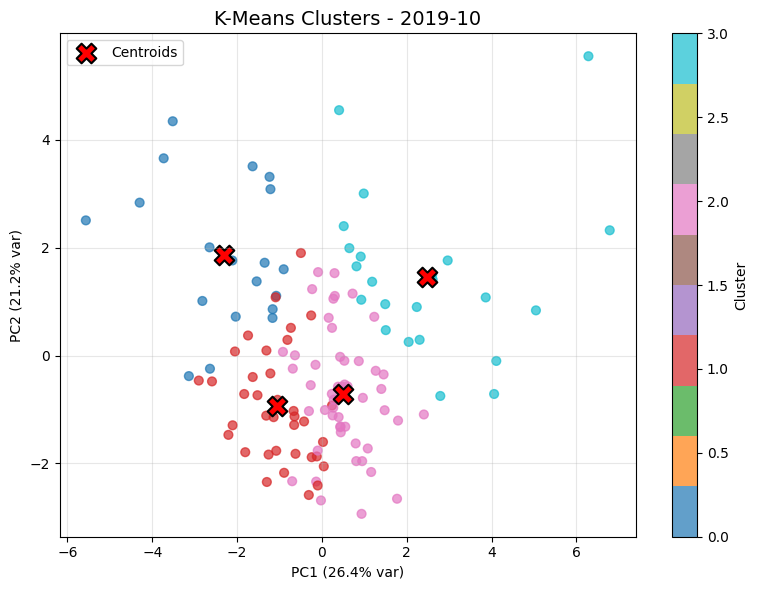

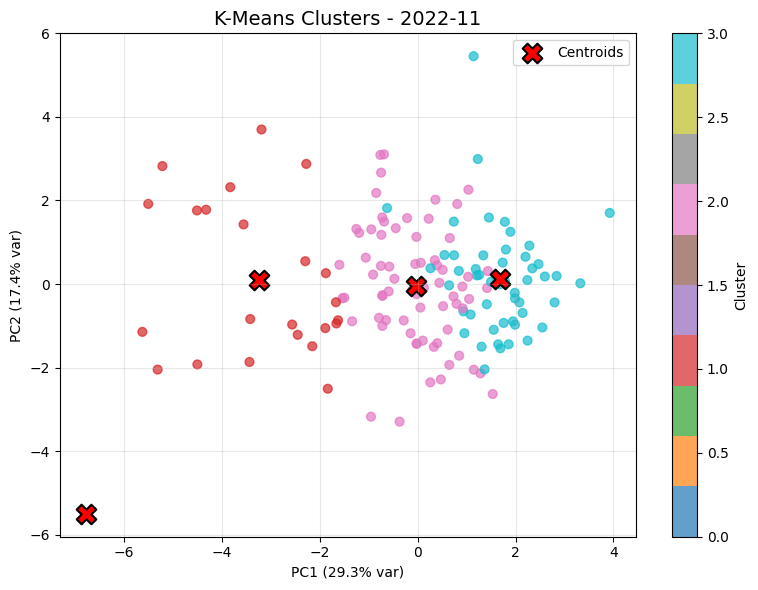

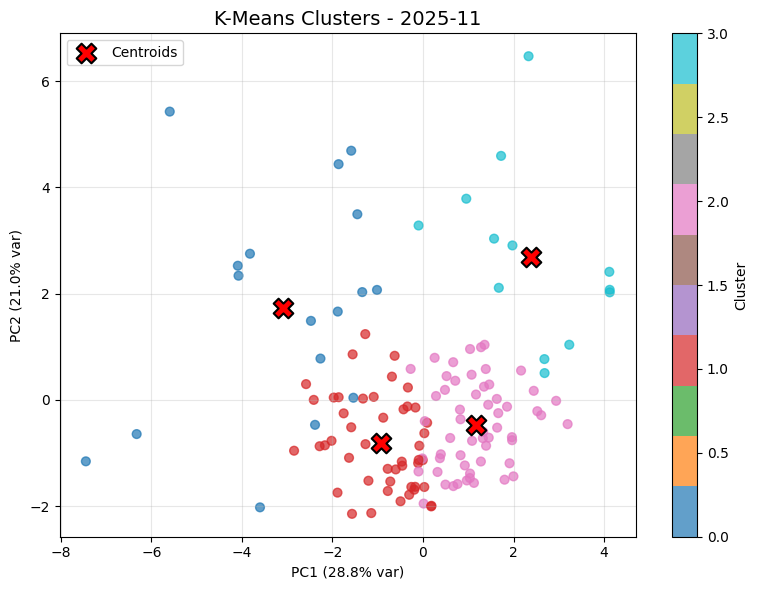

In [15]:
from sklearn.decomposition import PCA

# --- Visualization Function (One Plot Per Month) ---
def plot_monthly_clusters(df, date, max_points=300):
    # Early exit if the month has not enough data
    if len(df) == 0 or len(df) < 2:
        print(f"Skipping plotting for {date.strftime('%Y-%m-%d')}: Not enough data points ({len(df)}).")
        return

    # Extract the same features we used for clustering
    X = df[features].copy()

    # Drop rows with NaN values in features for this specific month's data
    X = X.dropna()
    # Check again after dropping NaNs
    if X.empty or len(X) < 2:
        print(f"Skipping plotting for {date.strftime('%Y-%m-%d')}: Not enough valid data points after NaN removal.")
        return

    # Standardize (mean = 0, std = 1) again for this month's data
    # Convert X to numpy array before fitting and transforming to prevent UserWarning
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    # Grab the cluster label (0-3) for each stock (ensure it matches X's index after dropna)
    labels = df.loc[X.index, 'cluster']

    # Principal Component Analysis (PCA)
    # Reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Randomly sample up to max_points (300) points for visualization if data is too large
    if len(X_pca) > max_points:
        idx = np.random.choice(len(X_pca), max_points, replace=False)
        X_pca = X_pca[idx]
        labels = labels.iloc[idx]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7, s=40)

    # Plot centroids
    if date in centroids_dict:
        # Centroids must be plotted on the same axes. They are already scaled from the clustering step.
        # We just need to transform them with the *current month's PCA* object.
        cents_scaled = centroids_dict[date]

        # Ensure the centroids have the correct number of features for this PCA
        if cents_scaled.shape[1] == X_scaled.shape[1]:
            cents_pca = pca.transform(cents_scaled)
            plt.scatter(cents_pca[:, 0], cents_pca[:, 1],
                        c='red', s=200, marker='X', edgecolors='black', linewidth=1.5, label='Centroids')
        else:
            print(f"Warning: Centroid dimensions for {date} do not match PCA dimensions. Skipping centroid plot.")

    plt.colorbar(scatter, label='Cluster')
    plt.title(f'K-Means Clusters - {date.strftime("%Y-%m")}', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -- Selecting Which Months to Plot

# 1. List of every month-end date in chronological order
all_dates = sorted(data_clustered.index.get_level_values('date').unique())

# 2. Get three periods
#   -- Why three? --
#   First --> see the clusters at the start of the sample.
#   Middle --> see how they evolve in the middle of the period.
#   Last --> see the most recent regime.

sample_dates = []
if len(all_dates) >= 1:
    sample_dates.append(all_dates[0])
if len(all_dates) >= 3:
    sample_dates.append(all_dates[len(all_dates)//2])
if len(all_dates) >= 2:
    sample_dates.append(all_dates[-1])

# Ensure unique dates in case of very short history
sample_dates = sorted(list(set(sample_dates)))

print(f"Plotting sample months: {sample_dates}")
for date in sample_dates:
    # slice the multi-index to get only that month
    month_data = data_clustered.xs(date, level='date', drop_level=False) 
    plot_monthly_clusters(month_data, date)

### Analyse the PCA Plots

We can’t draw 18 numbers, so we **squished them into 2** (like a map).

Each dot on the scatter plot represents a single stock for a specific month. The position of the dot (its x and y coordinates) is determined by its values on PC1 and PC2, which in turn reflect its underlying characteristics across all the financial features we used for clustering. Stocks that are similar in their behavior will appear close to each other on the plot.

#### Key insights:
**November 2019**
> * This period represents a relatively stable pre-pandemic market environment, characterized by moderate growth and low interest rates.
> * The plot for October 2019 likely shows **distinct and well-separated clusters**. All four clusters are clearly visible, with relatively defined boundaries. The centroids (red 'X's) are also well-dispersed across the PCA space.

**November 2022**
> * This period falls within a time of heightened inflation, rising interest rates, and geopolitical uncertainty, leading to market corrections and increased volatility.
> * Compared to 2019, this plot might exhibit less distinct separation between clusters, or some clusters appearing more condensed/sparse. For example, the 'Strong Momentum' (Cluster 3) and 'Stable Performers' (Cluster 2) might be less populated or closer to the 'Neutral' clusters (Cluster 1). Conversely, the 'Oversold/Underperforming' (Cluster 0) cluster might be more dominant or widely dispersed, indicating broad-based weakness.
> * This likely points to a risk-off or uncertain market regime. During such times, aggressive growth stocks (Cluster 3) tend to underperform due to higher discount rates and increased investor caution, causing their cluster to shrink or blend with others. Defensive or stable stocks (Cluster 2) might become relatively more attractive, but even they can experience pressure. The expansion of Cluster 0 suggests that many stocks are experiencing drawdowns, reflecting broad market weakness or fear. The reduced distinction between clusters could mean that the market is more correlated, with fewer clear winners and losers, making strategy selection more challenging.

**November 2025**
> * This plot represents a more recent (or projected) market state, potentially reflecting a recovery or a new economic cycle.
> * The pattern here would indicate the prevailing market sentiment. We might see clusters regaining their distinctiveness, perhaps with 'Strong Momentum' (Cluster 3) and 'Stable Performers' (Cluster 2) becoming prominent again. The centroids might have shifted to new positions, reflecting evolved stock characteristics and market drivers.
> * If the clusters are again well-separated, it suggests a return to a more normalized or growth-oriented market, similar to 2019, where specific behavioral styles are once again rewarded. A robust and clearly defined Cluster 3 would indicate renewed investor confidence and a preference for growth assets. If Cluster 2 is also strong, it means quality companies are valued. Conversely, if Cluster 0 remains large and central, it might suggest persistent challenges or a 'slow grind' recovery. This plot helps us understand the current dominant market narrative and whether it's a 'growth market,' a 'value market,' or a 'defensive market.'

#### Summary the insight

| Month | What the Picture Says |
|-------|------------------------|
| **2019** | 4 **clear teams** – market was calm |
| **2022** | Teams **mixed together** – market was crazy |
| **2025** | 4 **sharp teams again** – market has clear winners/losers |

**Big idea:**  
> The teams **change every month** depending on the market mood.  
> That’s why we **rebuild them every 30 days**.

## 5.3 Summary Table

The cluster summary table translates the complex, multi-dimensional characteristics of each stock cluster into an interpretable format using key financial metrics. By examining the average values of RSI, 1-month returns, Garman-Klass Volatility, and Market-RF beta for each cluster, we can assign meaningful "behavioral styles" to them, which directly informs trading decisions.

In [17]:
summary = (data_clustered
           .groupby('cluster')[['rsi', 'return_1m', 'gk_vol', 'Mkt-RF_beta']]
           .mean()
           .round(3))

print("\nCluster Interpretation (Monthly Averages):")
print(summary)


Cluster Interpretation (Monthly Averages):
            rsi  return_1m  gk_vol  Mkt-RF_beta
cluster                                        
0        37.922     -0.083   0.286        1.007
1        46.731     -0.021   0.267        0.994
2        55.932      0.038   0.246        0.990
3        64.461      0.112   0.278        1.146


### Analyse the result

As we have **500+ stocks** and **18 features** for each (like price change, risk, momentum, etc.). We used K-Means to group these stocks into 4 clusters, based on how they behave.

We **nudged** the computer to start grouping around:
- **RSI = 30**: “stocks that fell a lot” (oversold)
- **RSI = 45**: “normal” stocks
- **RSI = 55**: “doing okay”
- **RSI = 70**: “stocks that rose a lot” (overbought)

#### Key insights:

* **Cluster 0: "Oversold/Underperforming"**
> * **RSI (38)**: This low average RSI suggests that stocks in this cluster are generally considered 'oversold.' Their recent price movements have been predominantly downwards, indicating weakness.
> * **1-Month Return (-0.083)**: A significantly negative average 1-month return confirms that these stocks have been performing poorly over the very short term. They've lost substantial value recently.
> * **Garman-Klass Volatility (0.286)**: The moderate volatility indicates that while they're going down, the price swings are noticeable, but not necessarily extreme. This volatility is associated with negative performance.
> * **Market-RF Beta (1.001)**: A beta close to 1 implies that, on average, these stocks move roughly in line with the overall market. However, given their strong negative returns, they are clearly underperforming the market, even with similar systematic risk exposure.
> * **Review**: These are often described as 'falling knives'. They are stocks experiencing significant recent weakness, often due to negative news or market sentiment. While their oversold RSI might tempt contrarian investors, their strong negative momentum suggests caution.

* **Cluster 1: "Neutral/Recovering"**
> * **RSI (~46.731)**: A mid-range RSI, slightly below the neutral 50 level, indicates that these stocks are not strongly oversold or overbought. There's some underlying weakness, but it's not as pronounced as in Cluster 0.
> * **1-Month Return (-0.021)**: A mildly negative average 1-month return suggests these stocks have either slightly underperformed or are consolidating after a move. The losses are much smaller than in Cluster 0.
> * **Garman-Klass Volatility (0.266)**: This is the second-lowest volatility among the clusters, implying relatively more stable price movements compared to Cluster 0 and 3.
> * **Market-RF Beta (0.997)**: A beta just under 1 means these stocks are slightly less sensitive to overall market movements. They're not as aggressive as the market but still follow its general trend.
> * **Review**: These stocks are typically in a 'neutral' phase or might be 'recovering' from prior weakness. They lack strong directional momentum, making them less appealing for aggressive momentum strategies, but also less risky than the deeply oversold stocks. They could be candidates for value-oriented strategies seeking stabilization.

* **Cluster 2: "Stable/Steady Performers"**
> * **RSI (55.702)**: An RSI comfortably above 50, but not excessively high, indicates healthy, sustained upward momentum without reaching 'overbought' territory. These stocks are consistently strong.
> * **1-Month Return (0.036)**: A positive average 1-month return shows consistent appreciation over the short term. These are reliable performers.
> * **Garman-Klass Volatility (0.249)**: This is the lowest average volatility among all clusters, meaning stocks here exhibit the most stable and predictable price movements. They are less prone to sudden, large swings.
> * **Market-RF Beta (0.994)**: A beta slightly below 1 reinforces their stable and possibly defensive nature. These stocks tend to move with the market but might experience slightly smaller up and down movements.
> * **Review**: These stocks are typically 'quality' or 'stable growth' companies. They offer positive, consistent returns with lower risk due to their reduced volatility and slightly defensive market sensitivity. They might appeal to investors seeking steady performance and capital preservation.

* **Cluster 3: "Strong Momentum/Aggressive Growth"**
> * **RSI (64.739)**: The highest average RSI, nearing the 70 threshold, signals very strong upward momentum and suggests these stocks might be approaching 'overbought' conditions. They have experienced rapid price increases.
> * **1-Month Return (0.112)**: A significantly high positive average 1-month return confirms exceptional recent performance. These are the 'rocket ships' of the market.
> * **Garman-Klass Volatility (0.276)**: Moderate volatility, similar to Cluster 0, but in this case, the volatility is associated with strong positive gains. This implies that rapid gains can come with noticeable price fluctuations.
> * **Market-RF Beta (1.137)**: This is the highest average beta, significantly above 1. It means these stocks are highly sensitive to market movements and will amplify both market gains and losses. They are considered aggressive investments.
> * **Review**: These are the 'aggressive momentum' or 'high-growth' stocks. They are characterized by rapid price appreciation and strong market sensitivity. While they offer the highest recent returns, they also carry higher risk, faster price swings, and the potential for sharper pullbacks, especially if market sentiment shifts or if they become truly overbought. This is the cluster our trading strategy targets for its high momentum potential.
  
#### Summary the result

| Team | RSI | Next Month Return | Risk (Vol) | Review |
|------|-----|-------------------|------------|---------------------|
| **Team 0** | ~37 | **−5.8 %** | Medium | **"Falling Knife"** – Avoid! |
| **Team 1** | ~45 | −1.7 % | Medium | **"Average"** – Nothing special |
| **Team 2** | ~57 | **+3.1 %** | **Lowest** | **"Steady Winner"** – Good & safe |
| **Team 3** | ~69 | **+10.5 %** | Medium | **"Rocket Ship"** – Buy this! |

# 6. The Trading Strategy
This trading strategy focuses on identifying and leveraging 'Strong Momentum/Aggressive Growth' stocks (Cluster 3) from the K-Means clustering analysis. Each month, the strategy re-evaluates the market to select stocks belonging to this high-momentum cluster, then optimizes their portfolio weights based on historical daily prices to maximize risk-adjusted returns (Sharpe Ratio). The portfolio is held for one month, after which the process is repeated.

### Approach:
1.  **Monthly Re-clustering**: Stocks are re-clustered each month to identify the current 'Strong Momentum/Aggressive Growth' stocks (Cluster 3) based on their updated financial and technical characteristics.
2.  **Selection**: Only stocks assigned to Cluster 3 are considered for the portfolio.
3.  **Data Collection**: For the selected stocks, 12 months of historical daily closing prices are downloaded.
4.  **Portfolio Optimization**: Using the PyPortfolioOpt library, an Efficient Frontier optimizer is applied to the selected stocks to determine optimal weights. The optimization aims to maximize the Sharpe Ratio, with a constraint that no single stock can exceed 10% of the portfolio (for diversification).
5.  **Rebalancing**: The optimized portfolio is held for one month. At the end of the month, the entire process is repeated with new clustering results and fresh data, effectively rebalancing the portfolio monthly.
6.  **Transaction Costs**: A small transaction cost (0.05%) is applied to the portfolio on the first trading day of each month to reflect real-world trading expenses.

**Goal:** Beat the market (SPY) with **better returns and lower risk**

## 6.1. Filter to Cluster 3
Filter the `data_clustered` DataFrame to select only stocks belonging to cluster 3, and then reset the 'ticker' index to convert it into a regular column, storing the result in `filtered_df`.

In [18]:
import matplotlib.pyplot as plt  # For plotting
from matplotlib.ticker import PercentFormatter            # Nice % labels

# Filter rows where cluster = 3
filtered_df = data_clustered[data_clustered['cluster'] == 3].copy()

# Reset the 'ticker' index so we can work with it
filtered_df = filtered_df.reset_index(level=1)  # level=1 is 'ticker'

filtered_df

,ticker,close,gk_vol,rsi,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0,atr,...,return_3m,return_6m,return_9m,return_12m,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,cluster
date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,AAPL,62.189999,0.188614,70.814642,55.582010,59.340250,63.098490,12.666748,0.879133,1.150600,...,0.053028,0.036453,0.045662,0.010728,1.144831,0.007393,-0.589712,0.479615,0.246694,3
2019-10-31,AMAT,54.259998,0.216178,56.454708,48.419433,52.627500,56.835567,15.991893,0.693972,1.469146,...,0.031982,0.035276,0.037137,0.042627,1.479742,0.398515,0.095895,0.240985,-0.691869,3
2019-10-31,AMD,33.930000,0.307591,69.608542,27.432417,31.002000,34.571582,23.028079,0.910132,1.055016,...,0.036730,0.034826,0.037267,0.053229,1.668959,-0.514336,-0.725301,-0.184406,-0.261845,3
2019-10-31,BAC,31.270000,0.186483,62.527949,27.196967,30.136500,33.076033,19.508126,0.692803,0.604044,...,0.006370,0.003726,0.010478,0.010764,1.333143,-0.157298,1.429128,-0.573509,-0.623731,3
2019-10-31,BIIB,298.709991,0.333273,81.100032,183.036875,250.801501,318.566128,54.038454,0.853492,10.242339,...,0.078948,0.045105,-0.012259,-0.001536,0.051941,0.248498,-0.684211,-0.033212,0.508599,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30,LRCX,150.244995,0.449993,50.818298,138.873653,154.683250,170.492848,20.441253,0.359634,7.225130,...,0.144765,0.108937,0.077506,0.060937,2.025451,-1.377423,0.338281,-1.618374,-0.520386,3
2025-11-30,MRK,102.459999,0.328825,80.620172,79.227942,90.828500,102.429058,25.543873,1.001334,2.824139,...,0.067952,0.046430,0.011732,0.000670,0.399082,-0.352394,0.348700,-0.333194,-0.210343,3
2025-11-30,MU,219.869995,0.647023,50.021758,204.349343,230.644498,256.939654,22.801459,0.295124,15.263418,...,0.227046,0.151206,0.099498,0.069704,2.906219,-1.759766,1.079596,-0.328103,1.742591,3


## 6.2. Shift Dates Forward by 1 Month
We decide at month-end → buy next month

In [19]:
# Add 1 month to each date
filtered_df.index = filtered_df.index + pd.DateOffset(months=1)

# Reset and set multi-index again
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
filtered_df

close    gk_vol        rsi  BBL_20_2.0_2.0  \
date       ticker                                                    
2019-11-30 AAPL     62.189999  0.188614  70.814642       55.582010   
           AMAT     54.259998  0.216178  56.454708       48.419433   
           AMD      33.930000  0.307591  69.608542       27.432417   
           BAC      31.270000  0.186483  62.527949       27.196967   
           BIIB    298.709991  0.333273  81.100032      183.036875   
...                       ...       ...        ...             ...   
2025-12-30 LRCX    150.244995  0.449993  50.818298      138.873653   
           MRK     102.459999  0.328825  80.620172       79.227942   
           MU      219.869995  0.647023  50.021758      204.349343   
           NEM      86.820000  0.325796  52.264337       77.300156   
           REGN    764.424988  0.313105  77.936808      600.075130   

                   BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
date       ticker                                                   
2019-11-30 AAPL         59.340250       63.098490       12.666748   
           AMAT         52.627500       56.835567       15.991893   
           AMD          31.002000       34.571582       23.028079   
           BAC          30.136500       33.076033       19.508126   
           BIIB        250.801501      318.566128       54.038454   
...                           ...             ...             ...   
2025-12-30 LRCX        154.683250      170.492848       20.441253   
           MRK          90.828500      102.429058       25.543873   
           MU          230.644498      256.939654       22.801459   
           NEM          84.993000       92.685843       18.102299   
           REGN        686.413248      772.751366       25.156309   

                   BBP_20_2.0_2.0        atr       macd  ...  return_3m  \
date       ticker                                        ...              
2019-11-30 AAPL          0.879133   1.150600   1.668786  ...   0.053028   
           AMAT          0.693972   1.469146   1.292434  ...   0.031982   
           AMD           0.910132   1.055016   0.937380  ...   0.036730   
           BAC           0.692803   0.604044   0.790521  ...   0.006370   
           BIIB          0.853492  10.242339  18.619057  ...   0.078948   
...                           ...        ...        ...  ...        ...   
2025-12-30 LRCX          0.359634   7.225130   0.164455  ...   0.144765   
           MRK           1.001334   2.824139   3.654017  ...   0.067952   
           MU            0.295124  15.263418   4.134214  ...   0.227046   
           NEM           0.618747   3.521415   0.383389  ...   0.052807   
           REGN          0.951780  21.832653  39.598463  ...   0.095959   

                   return_6m  return_9m  return_12m  Mkt-RF_beta  SMB_beta  \
date       ticker                                                            
2019-11-30 AAPL     0.036453   0.045662    0.010728     1.144831  0.007393   
           AMAT     0.035276   0.037137    0.042627     1.479742  0.398515   
           AMD      0.034826   0.037267    0.053229     1.668959 -0.514336   
           BAC      0.003726   0.010478    0.010764     1.333143 -0.157298   
           BIIB     0.045105  -0.012259   -0.001536     0.051941  0.248498   
...                      ...        ...         ...          ...       ...   
2025-12-30 LRCX     0.108937   0.077506    0.060937     2.025451 -1.377423   
           MRK      0.046430   0.011732    0.000670     0.399082 -0.352394   
           MU       0.151206   0.099498    0.069704     2.906219 -1.759766   
           NEM      0.086694   0.081647    0.058994    -0.123415  0.274956   
           REGN     0.076833   0.010033    0.001564     1.081766 -0.622887   

                   HML_beta  RMW_beta  CMA_beta  cluster  
date       ticker                                         
2019-11-30 AAPL   -0.589712  0.479615  0.246694        3  
           AMAT    0.095895  0.240985 -0.691869

## 6.3. Create Monthly Buy Lists
Generate a dictionary of monthly 'buy lists', where each key is a future trading date and its value is a list of tickers selected for that month.

In [20]:
# Get the list of all months
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}
# This is your "buy list" per month = Dict
# e.g. '2025-01-31': ['AAPL', 'NVDA', 'TSLA', ...]
for d in dates:
    # Slice all stocks for that date
    tickers = filtered_df.xs(d, level=0).index.tolist()
    fixed_dates[d.strftime('%Y-%m-%d')] = tickers

print("Monthly Buy Lists (first 5 months):")
# Print the first 5 entries for brevity
for i, (date_str, ticker_list) in enumerate(fixed_dates.items()):
    if i >= 5:
        break
    print(f"  {date_str}: {ticker_list[:5]}... ({len(ticker_list)} stocks)")

Monthly Buy Lists (first 5 months):
  2019-11-30: ['AAPL', 'AMAT', 'AMD', 'BAC', 'BIIB']... (23 stocks)
  2019-12-30: ['ABBV', 'ADBE', 'ADSK', 'AMAT', 'AMD']... (26 stocks)
  2020-01-31: ['AAPL', 'ADBE', 'AMAT', 'AMD', 'BKNG']... (15 stocks)
  2020-02-29: ['ADSK', 'AMD', 'GE', 'LRCX', 'NFLX']... (9 stocks)
  2020-03-29: ['BIIB', 'REGN']... (2 stocks)


## 6.4. Define Portfolio Optimization Function
- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
- Apply stock weight bounds constraint for diversification.

In [21]:
from pypfopt import risk_models, expected_returns         # Risk & return calculators
from pypfopt.efficient_frontier import EfficientFrontier  # Portfolio optimizer

def optimize_weights(prices, lower_bound=0):
    # Calculate expected returns = Average past daily return × 252 (trading days/year)
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)

    # Calculate risk (covariance matrix – how stocks move together)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # EfficientFrontier: All possible "best" portfolios --> Math tool to find best weights
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, 0.1),  # No stock > 10%, min = lower_bound
                           solver='SCS')  # Solver = math algorithm

    # Max Sharpe: Pick the one with highest return per risk
    weights = ef.max_sharpe()

    # Clean up (round small weights to 0)
    return ef.clean_weights()

## 6.5. Download Fresh Daily Prices

In [22]:
# Get all unique stocks
stocks = data_clustered.index.get_level_values('ticker').unique().tolist()

# First date minus 12 months
first_date = data_clustered.index.get_level_values('date').min() - pd.DateOffset(months=12)

# Need daily data for accurate risk/return estimates
# 1 year lookback = enough history, not too old
new_df = yf.download(tickers=stocks,
                     start=first_date,
                     end=data_clustered.index.get_level_values('date').max(),
                     progress=False)

/var/folders/2c/m_n_s4tn1yl_wl0vsn5dn3880000gn/T/ipykernel_51527/126882752.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_df = yf.download(tickers=stocks,


## 6.6. Calculate Daily Returns

In [23]:
# Return = (new price / old) - 1 → here log for compounding
# diff = today − yesterday
# Log return ≈ % change (e.g. log(1.05) ≈ 0.0488 → + 4.88%)
close_prices = new_df['Close']
returns_dataframe = np.log(close_prices).diff()

## 6.7. Loop Over Months → Optimize → Apply Weights

In [24]:
# Store daily returns
portfolio_df = pd.DataFrame() 

print("Starting monthly portfolio construction...")

# Loop each month
for start_date in fixed_dates.keys():
    try:
        # 1. Define dates (e.g. 30/12 - 31/01)
        start_dt = pd.to_datetime(start_date)
        end_dt = start_dt + pd.offsets.MonthEnd(0)  # Go to last day of the month.
        end_date = end_dt.strftime('%Y-%m-%d')      # Turn back into string

        # 2. Get tickers for this month
        tickers = fixed_dates[start_date]
        # Need at least 2 stocks to build a portfolio
        if len(tickers) < 2:
            print(f"Skipping {start_date}: Only {len(tickers)} stock(s)")
            continue

        # 3. Go back 12 months for data - Use past year to guess future risk & return
        opt_start = (start_dt - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        opt_end   = (start_dt - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        # Get daily closing prices of our stocks
        try:
            price_history = close_prices.loc[opt_start:opt_end, tickers]
        except KeyError:
            print(f"Skipping {start_date}: No price data in lookback")
            continue

        if price_history.empty or price_history.isna().all().all():
            print(f"Skipping {start_date}: No valid price data")
            continue

        # Drop stocks with >50% missing data
        valid_tickers = price_history.columns[price_history.notna().mean() > 0.5]
        if len(valid_tickers) < 2:
            print(f"Skipping {start_date}: Too few valid stocks after cleaning")
            continue
        price_history = price_history[valid_tickers]

        # 4. Optimize weights
        success = False
        try:
            # Call function → get { 'AAPL': 0.08, 'NVDA': 0.12 }
            # Max Sharpe = best return per risk
            weights_dict = optimize_weights(
                prices=price_history,
                lower_bound=max(0.01, round(1 / (len(valid_tickers) * 2), 3))
            )
            weights = pd.DataFrame(weights_dict, index=[0])
            success = True
            print(f"{start_date}: Optimized {len(valid_tickers)} stocks")
        except Exception as e:
            # If math fails → split money equally
            print(f"{start_date}: Optimization failed ({e}) → Using equal weights")
            eq_w = 1.0 / len(valid_tickers)
            weights_dict = {t: eq_w for t in valid_tickers}
            weights = pd.DataFrame(weights_dict, index=[0])

        # 5. Get daily returns for holding period
        # How much each stock moved each day.
        try:
            daily_rets = returns_dataframe.loc[start_date:end_date, valid_tickers]
        except KeyError:
            print(f"Skipping {start_date}: No returns in holding period")
            continue

        if daily_rets.empty:
            continue

        # 6. Stack and merge with weights
        # e.g. AAPL: 0.01, NVDA: -0.02 --> Date: 2020-01-02, ticker: AAPL, return: 0.01
        daily_rets = daily_rets.stack().reset_index()
        daily_rets.columns = ['Date', 'ticker', 'return']

        # e.g. Turn {AAPL: 0.08} --> table with ticker, weight
        weights_long = weights.melt(var_name='ticker', value_name='weight')
        # e.g. Join AAPL return x AAPL weight
        merged = daily_rets.merge(weights_long, on='ticker', how='left')

        # Fill missing weights (shouldn't happen, but safe)
        merged['weight'] = merged['weight'].fillna(0)

        # 7. Add transaction cost (0.05% per rebalance)
        # Only charge once per month, on first trading day
        first_day = merged['Date'].min()
        merged.loc[merged['Date'] == first_day, 'return'] -= 0.0005  # 0.05%

        # 8. Weighted return
        # E.g. AAPL return = +2%
        #      Weight = 10%
        #      --> Contribution = +0.2% to portfolio
        merged['weighted_return'] = merged['return'] * merged['weight']

        # 9. Sum to daily portfolio return
        # One row for Total portfolio return per day
        daily_port = merged.groupby('Date')['weighted_return'].sum().to_frame('Strategy Return')

        # Append
        portfolio_df = pd.concat([portfolio_df, daily_port])

    except Exception as e:
        print(f"Error processing {start_date}: {e}")

# --- Final cleanup ---
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]
portfolio_df = portfolio_df.sort_index()

print(f"\nPortfolio built: {len(portfolio_df)} trading days")

Starting monthly portfolio construction...
2019-11-30: Optimized 23 stocks
2019-12-30: Optimized 26 stocks
2020-01-31: Optimized 15 stocks
2020-02-29: Optimization failed (('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')) → Using equal weights
2020-03-29: Optimization failed (('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')) → Using equal weights
Skipping 2020-04-30: Only 1 stock(s)
2020-05-30: Optimization failed (('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')) → Using equal weights
2020-06-30: Optimized 51 stocks
2020-07-30: Optimized 18 stocks
2020-08-31: Optimized 27 stocks
2020-09-30: Optimized 23 stocks
2020-10-30: Optimized 44 stocks
2020-11-30: Optimized 24 stocks
2020-12-30: Optimized 36 stocks
2021-01-31: Optimized 36 stocks
2021-02-28: Optimized 37 stocks
2021-03-28: Optimized 18 stocks
2021-04-30: Optimized 41 stocks
2

## 6.7. Build Portfolio Returns: Loop Over Months -> Optimize -> Apply Weights

In [25]:
spy_data = yf.download('SPY', start='2015-01-01', end=dt.date.today(), progress=False)
spy_close = spy_data['Close'] 

spy_returns_series = np.log(spy_close).diff().dropna()

# Give it a name
spy_returns_series.name = 'SPY'

# Convert to DataFrame if it's still a Series
if isinstance(spy_returns_series, pd.Series):
    spy_ret = spy_returns_series.to_frame()
else:
    spy_ret = spy_returns_series.copy()

print(f"SPY benchmark ready: {len(spy_ret)} trading days")

# Make sure dates are proper datetime
portfolio_df.index = pd.to_datetime(portfolio_df.index)
spy_ret.index = pd.to_datetime(spy_ret.index)
# Combine both tables
portfolio_df = portfolio_df.merge(
    spy_ret,
    left_index=True,
    right_index=True,
    how='left' 
)

# Fill weekends/holidays with previous day’s return
portfolio_df['SPY'] = portfolio_df['SPY'].ffill()

# Any remaining NaN → 0 (very rare)
portfolio_df = portfolio_df.fillna(0)

print(f"Final combined data: {len(portfolio_df)} days")

/var/folders/2c/m_n_s4tn1yl_wl0vsn5dn3880000gn/T/ipykernel_51527/2244863331.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download('SPY', start='2015-01-01', end=dt.date.today(), progress=False)


SPY benchmark ready: 2740 trading days
Final combined data: 76 days


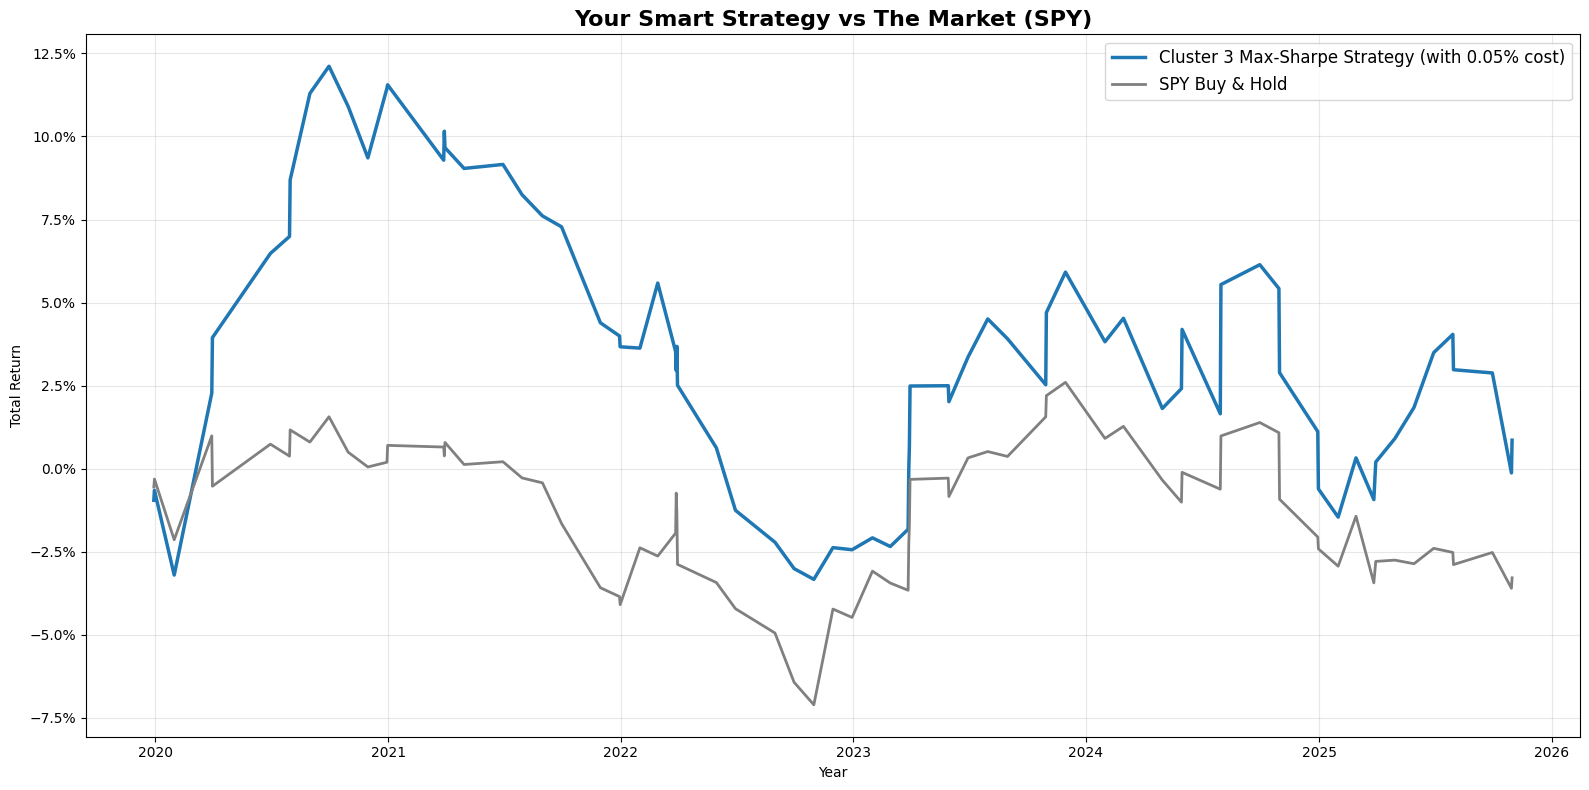

In [26]:
# Convert log returns → real growth ($1 → $X)
cum_returns = np.exp(np.log1p(portfolio_df).cumsum()) - 1

# Plot
plt.figure(figsize=(16, 8))
plt.plot(cum_returns['Strategy Return'], 
         label='Cluster 3 Max-Sharpe Strategy (with 0.05% cost)', 
         linewidth=2.5, color='#1f77b4')
plt.plot(cum_returns['SPY'], 
         label='SPY Buy & Hold', 
         linewidth=2, color='gray')

plt.title('Your Smart Strategy vs The Market (SPY)', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Return')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
def show_performance(col_name):
    returns = portfolio_df[col_name]
    total = (1 + returns).prod() - 1
    years = len(returns) / 252
    cagr = (1 + total) ** (1/years) - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    print(f"\n{col_name}")
    print(f"   Total Return : {total:.1%}")
    print(f"   CAGR         : {cagr:.1%}")
    print(f"   Sharpe Ratio : {sharpe:.2f}")

show_performance('Strategy Return')
show_performance('SPY')


Strategy Return
   Total Return : 0.9%
   CAGR         : 2.9%
   Sharpe Ratio : 0.24

SPY
   Total Return : -3.3%
   CAGR         : -10.5%
   Sharpe Ratio : -0.58
